In [1]:
library(ggplot2)
library(tibble)
library(Matrix)

# 4. Matrix completion

## Outline
Suppose $Y\in\mathbb R^{n\times d}$. Introduce missing values by projecting to domain $\Omega$, taken to be random samples from $Y$. We have the matrix completion problem,
$$
\min_X \left\{\frac{1}{2}\|\mathcal P_\Omega(Y)-\mathcal P_\Omega(X)\|_2^2+\lambda\|X\|_1\right\}
$$
The projection operator is simply element-wise multiplication by the indicator function, $\mathcal P_{\Omega}(X):=X\mathbf{1}_\Omega$. $\|A\|_p$ denotes the $p$-Schatten norm is $A$ is a matrix and $l^p$ norm if it is a vector.

The gradient of the differentiable part of this loss function is
$$
g(X):=\mathcal P_\Omega Y-\mathcal P_\Omega X.
$$
Proximal gradient descent has us computing
$$
X^+ = \text{prox}_{t\lambda}(X-t g(X)).
$$
Notice that the gradient has Lipschitz constant $1$. So, we are guaranteed convergence with  
$$
\begin{align*}
X^+ &= \text{prox}_{\lambda}(X-\mathcal P_\Omega X+ \mathcal P_\Omega Y)\\
&=\text{prox}_{\lambda}(\mathcal P_{\Omega^c} X+ \mathcal P_\Omega Y).
\end{align*}
$$

## Proximal operator for nuclear norm
**Prop** The prox operator, 
$$
\text{prox}_{\lambda\|\cdot\|_1}(X)=\arg\min_Z\left(\frac{1}{2}\|X-Z\|_2^2+\lambda \|Z\|_1\right)
$$
is given by SVD with the singular values being the soft-thresholded at level $\lambda$,
$$
U\text{diag}(\max(\Sigma_{ii}-\lambda,0))V^T
$$

**proof.** Start with SVD decomposition,
$$
X=U\Sigma V^T.
$$
Note that 
$$
\text{prox}_{\lambda\|\cdot\|_1}(U\Sigma V^T) = U\text{prox}_{\lambda\|\cdot\|_1}(\Sigma)V^T.
$$
because Schatten norms are unitary invariant/they depend only on singular values. Then, defining $\sigma:=\{\Sigma_{ii}|i\in[1, d]\}$,
$$
\text{prox}_{\lambda\|\cdot\|_1}(\sigma) = \arg\min_z\left(\frac{1}{2}\|\sigma-z\|_2^2+\lambda \|z\|_1\right)
$$
is now the proximal operator of the $l^1$ norm. Subgradient optimality reads
$$
\begin{align*}
0&\in (\sigma-z)+\lambda\partial\|z\|_1\\
z-\sigma&\in \lambda\partial\|z\|_1\\
z-\sigma&\in \left\{
\begin{array}{ll}
      \lambda & z>0\\
      -\lambda & z<0 \\
      [-\lambda,\lambda] & z=0\\
\end{array}
\right\}
\end{align*}
$$
which can be massaged into the soft-thresholding form,
$$
\text{prox}_{\lambda\|\cdot\|_1}(\sigma)=\text{sign}(\sigma)(|\sigma|-\lambda)_+
$$
Since singular values are positive, this simply becomes
$$
\text{prox}_{\lambda\|\cdot\|_1}(\sigma)=(\sigma-\lambda)_+
$$
Introducing the unitaries $U$ and $V$ back,
$$
\text{prox}_{\lambda\|\cdot\|_1}(X)=U\text{diag}((\sigma-\lambda)_+)V^T_{\quad \square}
$$


## Data

Let's generate random $n\times d$ Gaussian matrix with rank $k$. We do this by taking $k$ linear combinations of the outer product of random vectors of length $n$ and $d$. For finite random matrices, there is a finite probability of linear dependence among elements of this combination so we need to check that the desired rank is indeed achieved.

In [2]:
generate_data <- function(n=200, d=100, k=2, seed =42) 
{
    set.seed(seed)
    X <- rnorm(n)%o%rnorm(d)
    while((rankMatrix(X)[1])!=k)
        {for(rank_idx in seq(1, k-1)){X <- X +rnorm(n)%o%rnorm(d)}}
    mask <- matrix(as.integer(runif(n*d, 0, 2)), nrow=n, ncol=d)
    return(list(X=X, Y=mask*X, mask=mask))
}
data <- generate_data(n=100, d=20, k=5, seed =58)

## Implementation

In [3]:
nuclear.norm <- function(X){sum(svd(X)$d)}
l2.norm <- function(a) {sqrt(sum(a*a))}
prox.nuclear <- function(X, lam)
{
    usv <- svd(X)
    sigma <-  pmax(usv$d-lam, 0)
    return(usv$u%*%(sigma*diag(length(sigma)))%*%t(usv$v))
}
loss.matrix_comp <- function(X, y, mask, lam){0.5*sum((X*mask-y)**2)+lam*nuclear.norm(X)}
gd_step.matrix_comp <- function(X, Y, t, lam, mask) {prox.nuclear(X+t*(Y-X*mask), lam)}

In [4]:
fit.matrix_comp <- function(Y, mask, X_true=NULL, lam=0.1, max_iter=2000, t=1)
{
    d <- dim(Y)[2]
    n <- dim(Y)[1]
    X <- matrix(rnorm(d*n), nrow=n, ncol=d)
    loss <- NULL
    error1 <- NULL
    error2 <- NULL
    iter <- 0
    for(iter in seq(1, max_iter))
    {
        X <- gd_step.matrix_comp(X, Y, t, lam, mask)
        loss <- c(loss, loss.matrix_comp(X, Y, mask, lam))
        if(!is.null(X_true))
        {
            sing_true <- svd(X_true)$d
            sing_pred <- svd(X)$d
            k <- rankMatrix(X_true)
            error1 <- c(error1, l2.norm((sing_true-sing_pred)[1:k]))
            error2 <- c(error2, l2.norm(sing_true[-1:-k]-sing_pred[-1:-k]))
        }
    }
    return(list(X_pred=X, loss=loss,  error1=error1, error2=error2))
}

In [5]:
model.matrix_comp <- fit.matrix_comp(Y=data$Y, mask=data$mask, X_true=data$X)

## Evaluation

We check the correctness of the model by comparing (via $l^2$ norm) the singular values of the model output and the true matrix. A rank $k$ matrix will have $k$ non-zero singular values. We compare both the largest $k$ singular values and the smallest $d-k$ singular values of the model output to that of the true matrix.

In [6]:
df <- tibble(n.iter = 1:length(model.matrix_comp$error1) ,
loss = model.matrix_comp$loss ,
error.rank = model.matrix_comp$error1,
error.global = model.matrix_comp$error2)

null device 
          1

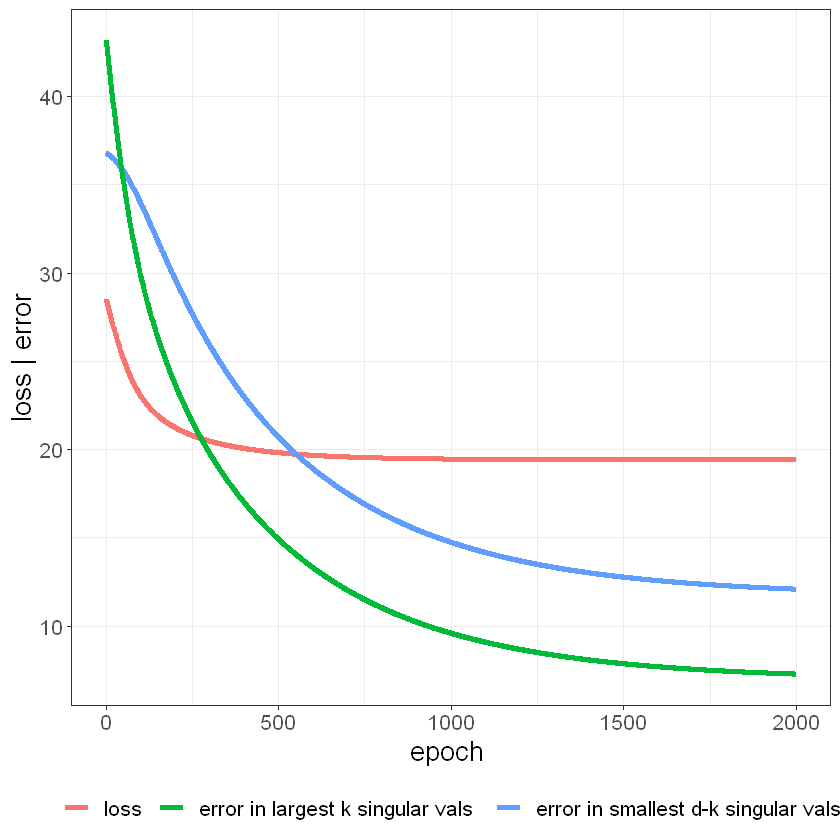

In [8]:
# pdf('Matconv4.pdf', width=10, height =6)
ggplot(data=df, aes(x=n.iter)) +
geom_line(aes(y=loss , color='blue'), lwd=1.5) +
geom_line(aes(y=error.rank , color='red'), lwd=1.5) +
geom_line(aes(y=error.global , color='magenta'), lwd=1.5) +
scale_color_discrete(
name = "", labels = c("loss", "error in largest k singular vals", "error in smallest d-k singular vals")) +
ylab('loss | error') +
xlab('epoch ') +
theme_bw() +
theme(legend.position='bottom', text = element_text(size = 16))
dev.off()